## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

%env CUDA_VISIBLE_DEVICES=0
import torch
import torchvision as tv
from torchvision import datasets, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import normalize

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import torch_dip_utils as utils
import math

import time

import pandas as pd

from AFSParser import build_dataset

env: CUDA_VISIBLE_DEVICES=0


# Check for GPU

In [2]:
CUDA = torch.cuda.is_available()
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")

False
NO DEVICES


# Hyperparams

In [3]:
LR = 1e-4 # learning rate
MOM = 0.9 # momentum
NUM_ITER = 3001 # number iterations
WD = 1e-4 # weight decay for l2-regularization
TV = 1e-1 # total variation regularisation 

# Get the data

In [28]:
# Load the data from the file
X, y = build_dataset(True)

# Choose an example from the dataset (arbitrary for now)
X, y = torch.from_numpy(X[0]).float(), torch.from_numpy(y[0]).float()
LENGTH = len(X) # number of frequency samples for this s4p chip


# Normalize then graph the data

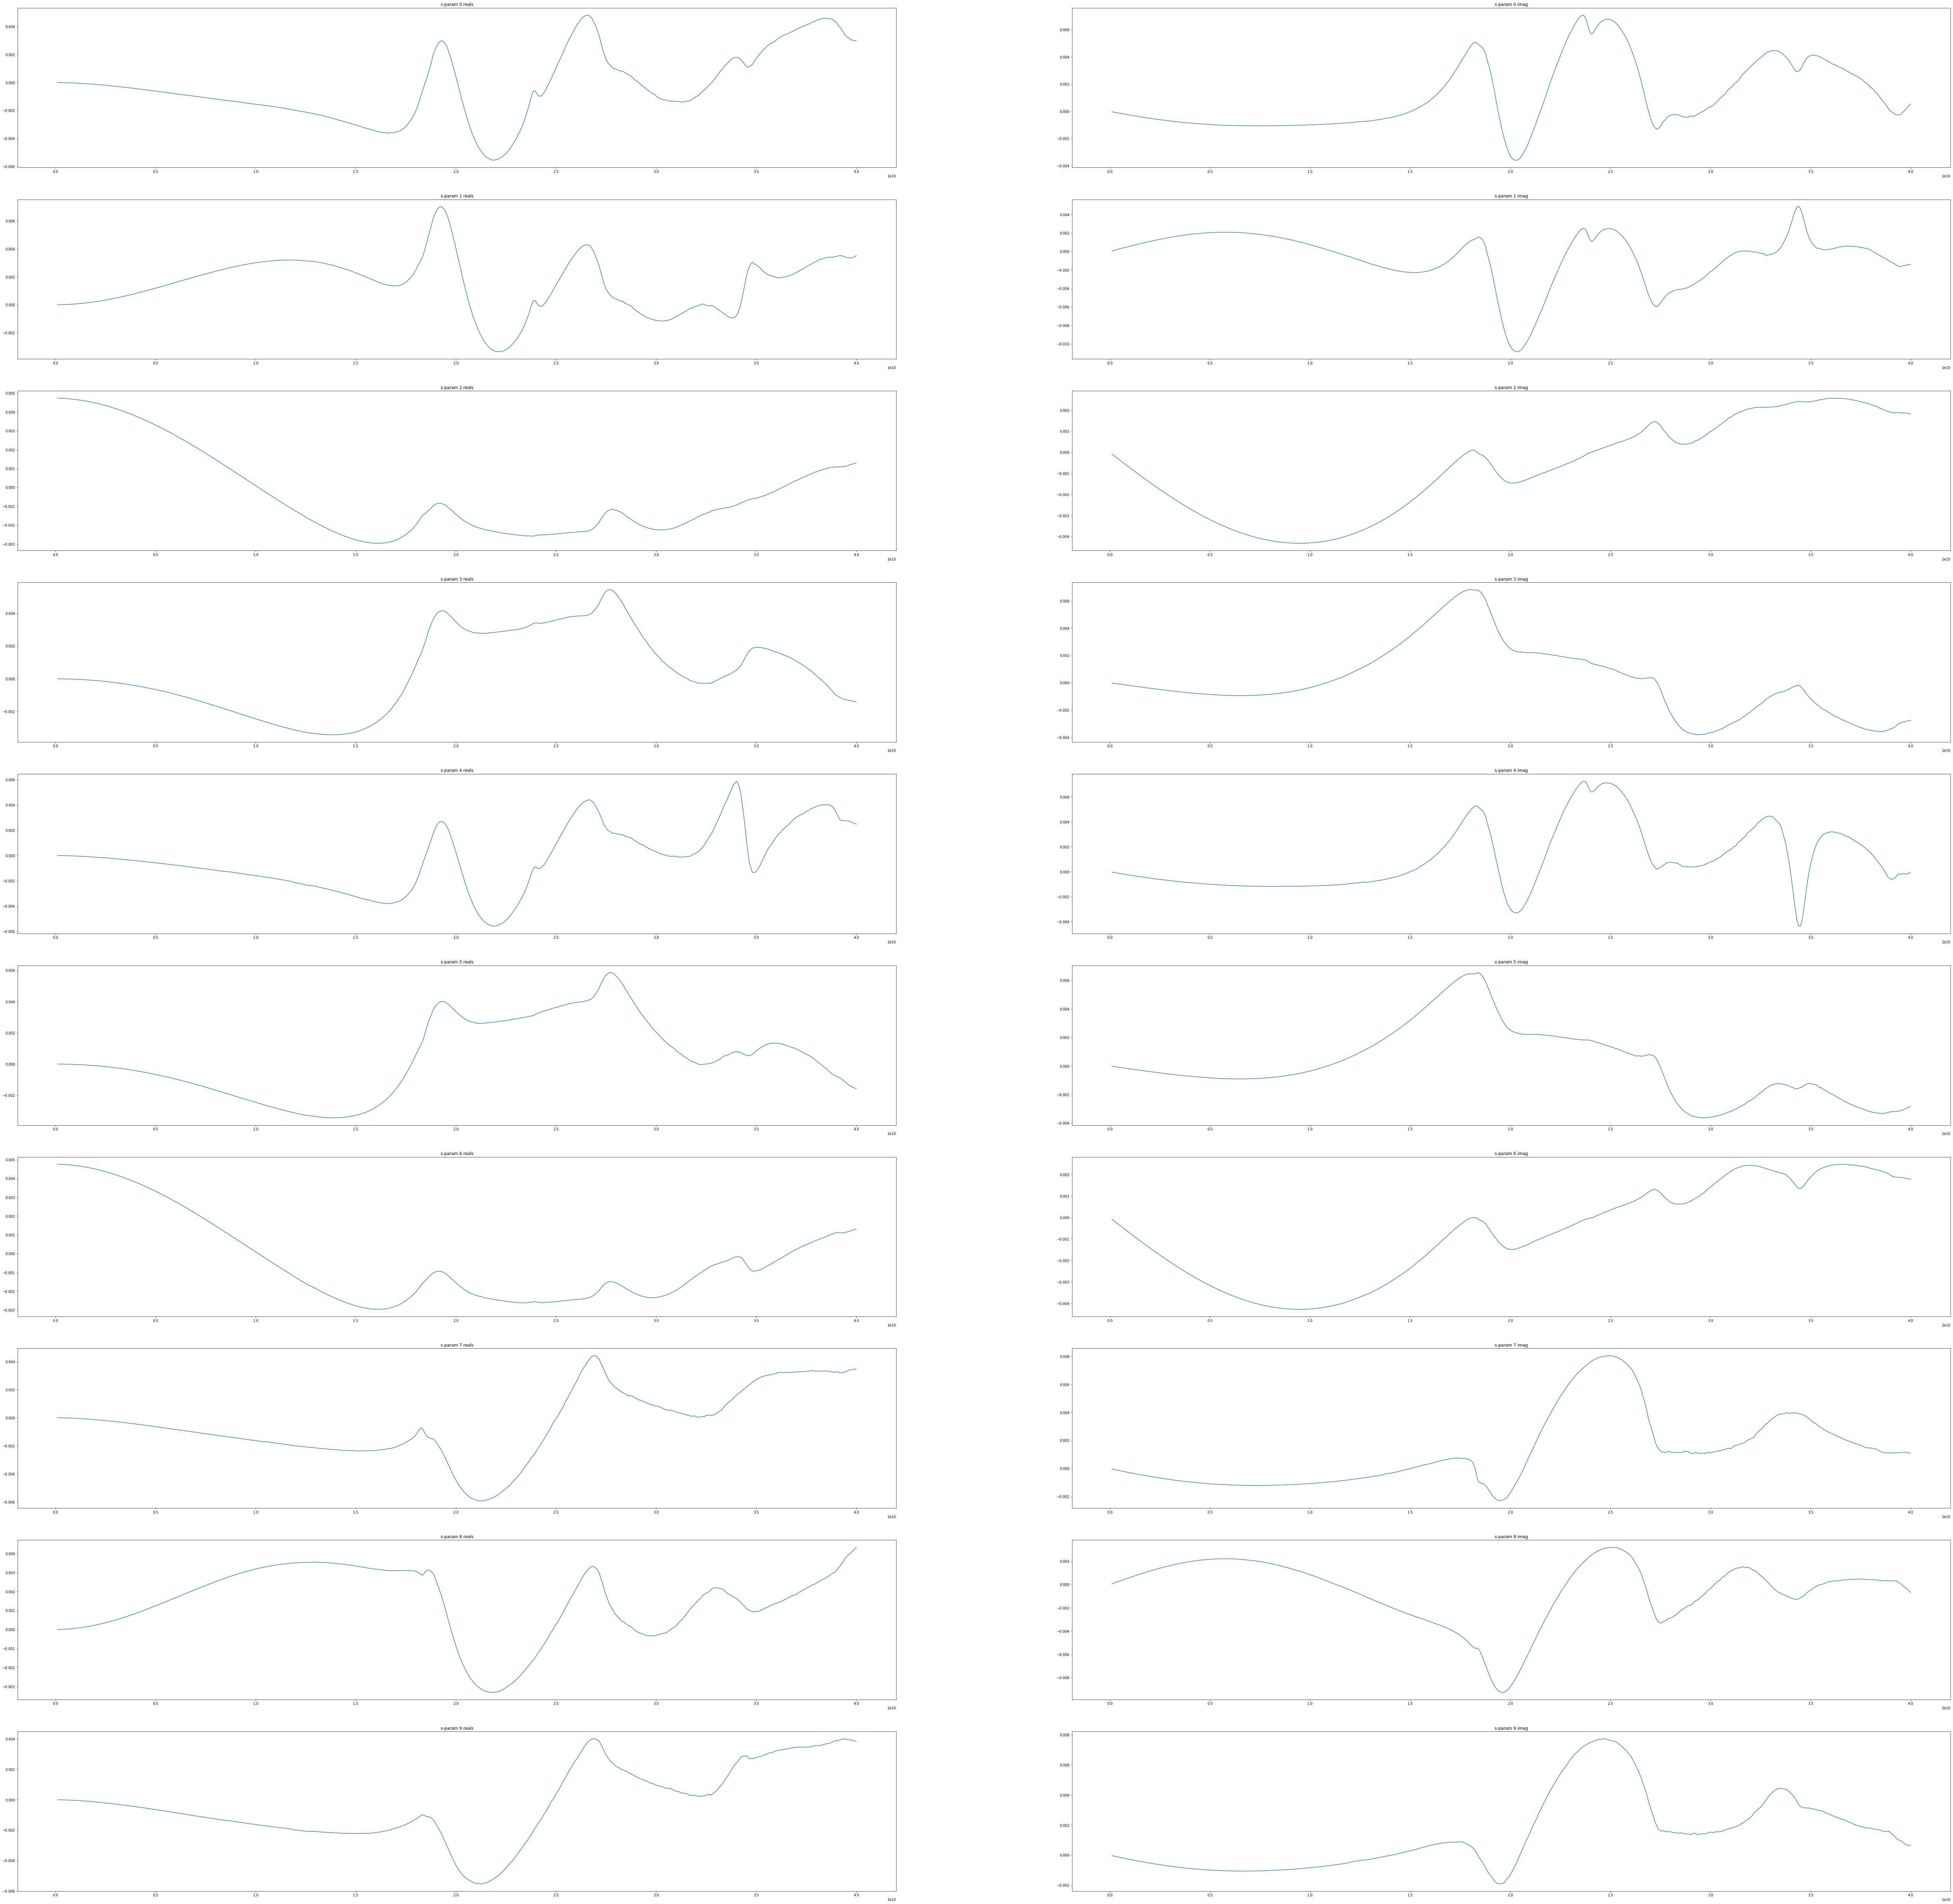

In [29]:
# TODO: No idea what is happening here
y_normalized = normalize(y, p=1.0, dim=0)
meas = y_normalized[::5]
y = torch.Tensor(meas)
y = Variable(y.type(dtype))

figure, axis = plt.subplots(10, 2, figsize=(100, 100))

for i in range(10):
    axis[i, 0].plot(X, y_normalized[:, i, 0]) # The reals for the i'th s-parameter
    axis[i, 0].set_title("s-param " + str(i) + " reals")
    axis[i, 1].plot(X, y_normalized[:, i, 1]) # The reals for the i'th s-parameter
    axis[i, 1].set_title("s-param " + str(i) + " imag")
plt.show()
